# Code to Analyze the membership ratio of RRLs
## What is this?
This is the code Cheng-You Ho (me) used to conduct my research on the membership ratio of RR Lyrae variable stars for my 2024 TISF project. I'll also publish this research on the Journal of Emerging Investigators as well as participate in 2024 MOSTRATEC in Brazil.

## Why do I need this?
Roughly one year ago, I wrote the code with the help of ChatGPT. It's not to blame, but there are many complicated parts of this code that needs some explanation. So I made this Jupyter Notebook to guide **anyone** who is interested in this research to know how to run the code.

This version of the notebook is made so that when adjusting for the appropriate shiftX and shiftY, GAIA database only needs to be queried ONCE.

shiftX and shiftY are added with input() prompts.

2024/08/28 Cheng-You Ho

## Necessary Libraries
First, let's install some necessary packages.

In [1]:
!pip install isochrones --quiet
!pip install PyAstronomy --quiet
!pip install numba --quiet
!pip install prettytable --quiet

## The weird *isochrone* library
Now we're gonna import the isochrone library and use the grid.df object. The weird thing about this is that if we just use it in the code, it's going to pop out **KeyError: -1.5** (or some other value) sooner or later. As of now I still don't know why, but a workaround is to **run grid.df** first and let the error occur. Miraculously, there will be no errors after that, so let's just stick with it. This may take some time (~5min).

In [2]:
from isochrones.mist import MISTIsochroneGrid
import pandas as pd
from collections import Counter
grid = MISTIsochroneGrid()
try: grid.df
except Exception as e: print("Expected Error: ", e) # This error is expected

PyMultiNest not imported.  MultiNest fits will not work.
C:\Users\cheng\anaconda3\Lib\site-packages\isochrones\mist\models.py:144: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(
C:\Users\cheng\anaconda3\Lib\site-packages\isochrones\mist\models.py:144: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(
C:\Users\cheng\anaconda3\Lib\site-packages\isochrones\mist\models.py:144: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(
C:\Users\cheng\anaconda3\Lib\site-packages\isochrones\mist\models.py:144: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df 

Expected Error:  -1.5


## Important functions
Time to declare some important functions. I'll skip the self-explanatory ones.
- **brToTemp**: Converts the (b-r) value to its effective temperature (Casagrande, L., Ramírez, I., Meléndez, J., Bessell, M., & Asplund, M. 2010, A&A, 512, A54).
- **LtoMbol**: Converts the luminosity of a star (unit: sun luminosity) to its absolute magnitude.
- **color_selector**: Used for generating the color map of different star types (regular, variable, etc.) on the resulting plot. Color is decided based on input_str. Returns a tuple. First element means to put text beside the star or not. Second element specifies the color.
- **variRule**: Probably the most important here. This function rules out any variable stars that are too far away from the isochrone line. For each variable (matching) star, the array dists[] stores the positional deviations to the matching star's +x, -x, +y, -y. The criteria is as follows: remove the star if there is too few **isochrone** (green) stars to the **right** *or* the **top** of the variable star in questions, with the threshold number of stars be called **ic_barrier**. The function then returns the x, y coordinates and id of the variable stars that fortunately "survived" the selection, meaning that they are likely to match the isochrone line.

In [7]:
import math, numba
from isochrones.mist import MISTIsochroneGrid
import matplotlib.pyplot as plt
import datetime
from astroquery.gaia import Gaia
import numpy as np
from openpyxl import load_workbook
from prettytable import PrettyTable
import pyperclip

all_rows = None

L_sun = 3.846e26
Mbol_sun = 4.75

def get_formatted_time():
     # Get the current time
    current_time = datetime.datetime.now()
    # Format the current time into a human-readable string
    formatted_time = current_time.strftime("%H%M%S-%Y%m%d")
    return formatted_time

# Casagrande, L., Ramírez, I., Meléndez, J., Bessell, M., & Asplund, M. 2010, A&A, 512, A54
# temp_casagrande = 10 ** (3.939 - 0.395 * br_color)
def brToTemp(br_color):
  return 10 ** (3.939 - 0.395 * br_color)

def LtoMbol(L): # L is already in the units of the luminosity of the sun (aka a ratio)
  return -2.5*math.log10(L)

def plotIsochrone(age=5, metallicity=-4, df_error=0.2):
  # Load isochrone grid data
  grid = MISTIsochroneGrid()
  legend_labels = []
  isochrone_data = grid.df.loc[grid.df["feh"].between(metallicity-df_error/2, metallicity+df_error/2) & grid.df["age"].between(age-df_error/2, age+df_error/2)]
  x_axis = [Ballesteros.t2bv(math.pow(10, logT)) for logT in isochrone_data['logTeff']]
  y_axis = [LtoMbol(math.pow(10, logL)) for logL in isochrone_data['logL']]
  plt.scatter(
      x_axis,
      y_axis,
      label=f'[Fe/H] = {metallicity}',
      s=3
  )

  # Add label to the legend
  legend_labels.append(f'[Fe/H] = {metallicity}')

  # Add labels and title
  plt.xlabel('Color (B-V)')
  plt.ylabel('Magnitude')
  plt.title(f'Hertzsprung-Russell Diagram for age={age}')

  # Invert y-axis for Luminosity
  plt.gca().invert_yaxis()

  # Add legend with labels from the loop
  plt.legend(legend_labels)

  # Show the plot
  plt.show()

# Define the equation for Mv as a function
def calculate_Mv(BV):
    return -6.3652 * BV**6 + 31.674 * BV**5 - 55.067 * BV**4 + 40.913 * BV**3 - 13.276 * BV**2 + 7.8757 * BV + 0.87

def getExcelColNames():
    ret = []
    for cell in all_rows[0]:
        ret.append(cell.value)
    return ret

def findItemInArr(arr, item):
    for index, value in enumerate(arr):
        if value == item:
            return index
    return -1  # Item not found

def color_selector(input_str): # 1st: need text or not, 2nd: plot it or not
    input_str = input_str.upper()
    if input_str == 'RR':
        return (False, 'red')
    elif input_str == 'ACV|CP|MCP|ROAM|ROAP|SXARI':
        return (False, False)
        # return (False, 'fuchsia')
    elif input_str in ['ECL', 'MICROLENSING', 'SOLAR_LIKE', 'EP']:
        return (False, False)
    else:
        # return (True, 'fuchsia')
        return (False, False)

def plotIsochroneLog(age=5, metallicity=-4, df_error=0.2):
  # Load isochrone grid data
  grid = MISTIsochroneGrid()
  legend_labels = []
  isochrone_data = grid.df.loc[grid.df["feh"].between(metallicity-df_error/2, metallicity+df_error/2) & grid.df["age"].between(age-df_error/2, age+df_error/2)]
  print("Total stars: ", len(isochrone_data))
  x_axis = isochrone_data['logTeff']
  y_axis = isochrone_data['logL']
  # Create the HR Diagram
  plt.scatter(
      x_axis,
      y_axis,
      label=f'[Fe/H] = {metallicity}',
      s=3
  )

  # Add label to the legend
  legend_labels.append(f'[Fe/H] = {metallicity}')

  # Add labels and title
  plt.xlabel('logTeff')
  plt.ylabel('logL')
  plt.title(f'Hertzsprung-Russell Diagram for age={age}')

  # Invert y-axis for Luminosity
  # plt.gca().invert_yaxis()
  plt.gca().invert_xaxis()

  # Add legend with labels from the loop
  plt.legend(legend_labels)

  # Show the plot
  plt.show()

def isBetween(x, lowerBound, upperBound):
  return x < upperBound and x > lowerBound

def variRule(isochrone_x, isochrone_y, matching_x, matching_y, matching_id, ic_barrier=10, x_search_error=1000, y_search_error=1, variRuleLog=True):
  print("IC Barrier: ", ic_barrier)
  discarded=0
  log_keep = []; log_discard = [];
  ret_x=[]; ret_y=[]; ret_id=[];

  for mx, my, mID in zip(matching_x, matching_y, matching_id):
    dists = [[], [], [], []] # to the matching star's +x, -x, +y, -y
    
    # Note that if x<mx, x is actually to the right of mx on HRD or CMD
    for x, y in zip(isochrone_x, isochrone_y):
      if isBetween(x, mx-x_search_error, mx+x_search_error) and isBetween(y, my-y_search_error, my+y_search_error):
        if x<mx: dists[1].append(mx-x)
        elif x>mx: dists[0].append(x-mx)
        if y<my: dists[3].append(my-y)
        elif y>my: dists[2].append(y-my)
            
    if len(dists[2])<ic_barrier or len(dists[0])<ic_barrier: # Those that are to the bottom in HRD
      log_discard.append([len(item) for item in dists])
      discarded+=1
      continue
    else:
      log_keep.append([len(item) for item in dists])

    ret_x.append(mx); ret_y.append(my); ret_id.append(mID)

  if variRuleLog:
    print("----- VariRULE LOG -----")
    for i, value in enumerate(log_keep):
      print(value)
    for i, value in enumerate(log_discard):
      print(value, "Discarded")

  print("Discarded Variable Stars: ", discarded)
  assert(len(ret_y)==len(ret_id) and len(ret_x)==len(ret_y))
  print("Star count after rule (x, y, id):", len(ret_x), len(ret_y), len(ret_id))
  return [ret_x, ret_y, ret_id, discarded]

## The Main Function
Here comes the main function! It's called "Gaia Analyze Isochrones Titled" where "Titled" means the titles of the plots are reasonable to be put on research papers.

### Fetching Data
Star name, RA and DEC are fetched from the **data_file** excel file. If the search dimensions is not specified in the Excel file, the manual preset dimension will be used. The dimension of the cluster is converted to **minutes** and multipled by **radius_factor~$0.25$** so that an appropriate space is searched.

### gaia_source
Queries the **gaia_source** table for all the stars in the desired region. The arrays x1 & y1 store the coordinates for the Color-Magnitude Diagram (CMD, x: temperature, y: visual magnitude) and x2 & y2 for the DEC-RA plot (visualization in the sky).

### vari_summary
All the SOURCE_ID values are queried into the **vari_summary** table and all the SOURCE_IDs that are variable stars will be returned. The results are stored in matching_x and matching_y.

### The Isochrone Line
The isochrone line is composed of many points on the CMD / HRD from grid.df, given the range of FeH and age one should fetch from the dataframe.
```
grid.df["feh"].between(metallicity-df_error/2, metallicity+df_error/2) & grid.df["age"].between(age-df_error/2, age+df_error/2)]
```
As you can see, selection of FeH is centered at **metallicity** with an error of **df_error**, while age is centered at **age** with an error of **df_error**. Hence **error** is probably a badly used word that should mean the range of values selected.

### Shifting
x_isochrone and y_isochrone are shifted based on the shiftX and shiftY values and passed into the **variRule** function described earlier. The results are stored in **variRuleFilter** and the coordinates of the variable stars that survive the filter are overwritten to matching_x and matching_y.

### vari_classifier_result
The survived variable stars' IDs are passed into the vari_classifier_result table to search for their variable star types, with RRL the main focus of this research.

## Running the code
Let's run the main function. One should pass all the parameters the function demands and try not to rely on the default values.
| Argument            | Default Value              |
|---------------------|----------------------------|
| `plot_vari`         | `True`                     |
| `variRuleLog`       | `True`                     |
| `force_manual_dim`  | `False`                    |
| `set_xlim_first`    | `15000`                    |
| `do_isochrone`      | `True`                     |
| `default_dim_min`   | `20`                       |
| `shiftX`            | `0`                        |
| `shiftY`            | `0`                        |
| `ic_barrier`        | `5`                        |
| `x_search_error`    | `1000`                     |
| `y_search_error`    | `1`                        |
| `data_file`         | `'AgeComparison.xlsx'`     |
| `star_name`         | `"M2"`                     |
| `radius_factor`     | `1`                        |
| `excel_target_row`  | `1`                        |
| `sheetRowCounter`   | `4`                        |
| `search_rows`       | `10000000`                 |
| `metallicity`       | `-4`                       |
| `age`               | `10`                       |
| `df_error`          | `0.4`                      |



In [14]:
# @title GAIA+Isochrone (Research Titles)
def gaiaAnalyzeIsochroneDataDict(plot_vari=True, variRuleLog=True, force_manual_dim=False, set_xlim_first=15000, do_isochrone=True, x_search_error=1000, y_search_error=1, data_file = 'GCdata.xlsx', row_number = -1, search_rows = 1e7, df_error=0.4, ic_barrier=0):
    finalLog = "" # Final log of this script
    wb = load_workbook(data_file)
    # Load one worksheet.
    ws = wb["NoIsochrone"]
    data_dict = {}
    headers = [cell.value for cell in ws[1]]
    row_data = [cell.value for cell in ws[row_number]]
    data_dict = dict(zip(headers, row_data))
    
    ws_backup = wb["RRppm_backup"]
    data_dict_backup = {}
    headers_backup = [cell.value for cell in ws_backup[1]]
    row_data_backup = [cell.value for cell in ws_backup[row_number]]
    data_dict_backup = dict(zip(headers_backup, row_data_backup))

    # RA value: convert to degree
    cluster_name = data_dict['Cluster Name']
    ra_h = data_dict['RA_h']
    ra_m = data_dict['RA_m']
    ra_s = data_dict['RA_s']

    print(cluster_name)

    # DEC: convert to degree
    dec_deg = data_dict['DEC_deg']
    dec_min = data_dict['DEC_min']
    dec_sec = data_dict['DEC_sec']
    
    metallicity  = max(data_dict['Metallicity'], -1.5) # Grid doesn't have much data points below FeH -1.5
#     age  = data_dict['Age']
    age = 10 # Not much data points for large ages

    mid_ra = ra_h * 15 + ra_m * 0.25 + ra_s / 240
    mid_dec = dec_deg + dec_min / 60 + dec_sec / 3600

    dim_provided = True # Whether the dimensions of the cluster is provided in the Excel file
    dim_min = data_dict.get('Dim_GAIA', -1)
    print(f"Dim_GAIA = {dim_min}")

    dim_deg = dim_min / 60
    search_dim = dim_deg

    # Get the current time
    current_time = datetime.datetime.now()
    # Format the current time into a human-readable string
    formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
    print("Current time:", formatted_time)

    ra_query = "ra BETWEEN " + str(mid_ra - search_dim/2) + " AND " + str(mid_ra + search_dim/2)
    dec_query = "dec BETWEEN " + str(mid_dec - search_dim/2) + " AND " + str(mid_dec + search_dim/2)

    query = f"SELECT TOP {str(int(search_rows))} SOURCE_ID, ra, dec, phot_rp_mean_mag, phot_g_mean_mag, phot_bp_mean_mag FROM gaiadr3.gaia_source WHERE {ra_query} AND {dec_query}"
    print(query)

    job = Gaia.launch_job(query)
    results = job.get_results()
    print("GAIA_SOURCE query completed. Total data count: ", len(results))

    columns = results.colnames

    id_col = findItemInArr(columns, "SOURCE_ID")
    ra_col = findItemInArr(columns, "ra")
    dec_col = findItemInArr(columns, "dec")
    red_col = findItemInArr(columns, "phot_rp_mean_mag")
    green_col = findItemInArr(columns, "phot_g_mean_mag")
    blue_col = findItemInArr(columns, "phot_bp_mean_mag")

    resultIDs = [item[id_col] for item in results]
    assert id_col >= 0 and ra_col >= 0 and dec_col >= 0 and red_col >= 0 and green_col >= 0 and blue_col >= 0, "One or more values are less than 0"

    x1 = []; y1 = []  # CMD plot
    x2 = []; y2 = []  # DEC-RA plot
    L = len(results)
    for item in results:
        # id_ = int(item[id_col])
        apparent_g = item[green_col]
        apparent_b = item[blue_col]
        apparent_r = item[red_col]
        ra = item[ra_col]
        dec = item[dec_col]

        x1.append(brToTemp(apparent_b - apparent_r))
        # x1.append(apparent_b - apparent_r)
        y1.append(apparent_r)
        x2.append(ra)
        y2.append(dec)

    # print(x1)
    plt.xlabel("ra")
    plt.ylabel("dec")
    assert(len(x1)==len(y1))
    assert(len(x2)==len(y2))

    finalLog += "Total stars before filter: "+str(len(x1))+' ';

    # Additional Query to get source_ids from vari_summary table
    
    # vari_query often too long!
    matching_x = []
    matching_y = []
#     vari_query = "SELECT source_id FROM gaiadr3.vari_summary WHERE SOURCE_ID IN (" + ", ".join([str(item) for item in resultIDs]) + ")"
#     print(f"Length of vari_query: {len(vari_query)}")
#     vari_job = Gaia.launch_job(vari_query)
#     vari_results = vari_job.get_results()
#     # vari_results = vari_job.get_results()
#     matching_ids = [int(item['SOURCE_ID']) for item in vari_results] # ID values that show up both in vari_summary and gaia_source
    
    batch_size = 20000
    
    matching_ids = []
    
    batch_number = len(resultIDs) // batch_size+1
    
    print(f"Querying vari_summary with {batch_number} batches.")

    # Process in batches of 1000 IDs
    for i in range(0, len(resultIDs), batch_size):
        # Get the current batch
        current_batch = resultIDs[i:i + batch_size]

        # Construct the query for the current batch
        vari_query = "SELECT source_id FROM gaiadr3.vari_summary WHERE SOURCE_ID IN (" + ", ".join([str(item) for item in current_batch]) + ")"
        print(f"Processing batch {i // batch_size + 1} / {batch_number}: {len(vari_query)} characters in query")

        # Execute the query
        vari_job = Gaia.launch_job(vari_query)
        vari_results = vari_job.get_results()

        # Combine results into matching_ids
        matching_ids.extend(int(item['SOURCE_ID']) for item in vari_results)

    print(f"Total matching IDs: {len(matching_ids)}")
    
    print(f"VARI_SUMMARY query completed. Number of variable stars: {len(matching_ids)}")
    
    for i, iden in enumerate(matching_ids):
        idx = resultIDs.index(iden) # id() is a Python function, idiot. 20240811 to 1 year ago me
        matching_x.append(x1[idx])
        matching_y.append(y1[idx])

    # Add matching_ids to the "variable_id" column in the worksheet
    variable_id_col = 8
    best_class_col = 9
    class_score_col = 10
    class_best_name=[]

    assert(len(matching_x)==len(matching_y) and len(matching_x)==len(matching_ids))

    # Isochrone lines
    # grid = MISTIsochroneGrid()
    legend_labels = []
    print(f"Metallicity = {metallicity}, age={age}")
    isochrone_data = grid.df.loc[grid.df["feh"].between(metallicity-df_error/2, metallicity+df_error/2) & grid.df["age"].between(age-df_error/2, age+df_error/2)]
    # print("Total rows: ", len(isochrone_data))
    x_isochrone_grid = [math.pow(10, logT) for logT in isochrone_data['logTeff']]
    y_isochrone_grid = [LtoMbol(math.pow(10, logL)) for logL in isochrone_data['logL']]

    print("Grid length, ", len(x_isochrone_grid))
    
    # Select particular points to spread evenly along the y-axis (y-values are as even as possible)
    num_points_to_select = 10000  # Change this to the desired number of points
    selected_indices = []
    y_sorted_indices = sorted(range(len(y_isochrone_grid)), key=lambda k: y_isochrone_grid[k])
    step = len(y_isochrone_grid) // num_points_to_select
    for i in range(num_points_to_select):
        selected_indices.append(y_sorted_indices[i * step])
        
    print("Preliminary GAIA query completed. Moving on to isochrone fitting.")
        
#     while True:
         
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)
#         shiftX = float(input("Please enter shiftX: "))
#         shiftY = float(input("Please enter shiftY: "))

    shiftX = data_dict['shiftX']
    shiftY = data_dict['shiftY']

    x_isochrone = [x_isochrone_grid[i] for i in selected_indices]
    y_isochrone = [y_isochrone_grid[i] for i in selected_indices]

    x_isochrone_shifted = [item+shiftX for item in x_isochrone]
    y_isochrone_shifted = [item+shiftY for item in y_isochrone]

    # Create the right plot (RA vs DEC)
    axs[0].scatter(x1, y1, s=0.03, color='blue', label='Regular Stars')
    axs[1].scatter(x2, y2, s=0.03, color='deepskyblue', label='Non-matching Stars')

    axs[0].set_ylabel("r (mag)", fontsize = 18)
    axs[0].set_xlabel("Temperature (K)", fontsize = 18)
    axs[0].set_xlim(set_xlim_first, 0)
    axs[0].invert_yaxis()

    # axs[0].set_title(star_name + ", radius=" + str(format(search_dim, ".3f")) + "', vari_count=" + str(vari_count) + ", shift=" + str([shiftX, shiftY]))
    axs[0].set_title(f"CMD for {cluster_name}", fontsize = 20)
    axs[1].set_title(f"DEC-RA Plot", fontsize = 20)

    axs[1].set_xlabel("ra (deg)", fontsize = 18)
    axs[1].set_ylabel("dec (deg)", fontsize = 18)

    axs[0].tick_params(axis='x', labelsize=18)
    axs[0].tick_params(axis='y', labelsize=18)
    axs[1].tick_params(axis='x', labelsize=18)
    axs[1].tick_params(axis='y', labelsize=18)

    # Rotate the tick numbers
    plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

    axs[0].scatter(
      x_isochrone_shifted,
      y_isochrone_shifted,
      label=f'[Fe/H] = {metallicity}',
      s=3,
      color='limegreen',
      alpha=0.2
    )

    plt.tight_layout(w_pad=2)
    plt.show()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

    variRuleFilter = variRule(x_isochrone_shifted, y_isochrone_shifted, matching_x, matching_y, matching_ids, ic_barrier=ic_barrier, x_search_error=x_search_error, y_search_error=y_search_error, variRuleLog=variRuleLog)

    matching_x_filtered, matching_y_filtered, matching_ids_filtered, discardedVariables = variRuleFilter[0], variRuleFilter[1], variRuleFilter[2], variRuleFilter[3];
    
    if variable_id_col>=0: # Column found
        # Additional Query to get class results
        class_query = "SELECT SOURCE_ID, best_class_name, best_class_score FROM gaiadr3.vari_classifier_result WHERE source_id IN (" + ", ".join([str(int(item)) for item in matching_ids]) + ")"
        print(class_query[:100] + "...")
        class_job = Gaia.launch_job(class_query)
        class_results = class_job.get_results()
        class_source_ids = [str(item['SOURCE_ID']) for item in class_results]
        class_best_names = [str(item['best_class_name']) for item in class_results]
        class_scores = [float(item['best_class_score']) for item in class_results]
        assert(len(class_source_ids)==len(class_best_names))
        finalLog += "Stars after rule and db search:"+str(len(class_source_ids)) + " "
        print("VARI_CLASSIFIER_RESULT query completed. ")

        print("EXCEL file modification completed.")

    else:
        print("WARNING: NO COLUMN FOR VARIABLE_ID")

#         wb.save(data_file)
#         print("Excel file: " + data_file + " saved.")

    assert(len(matching_x_filtered)==len(matching_y_filtered))
    vari_count = len(matching_x_filtered)

    # Additional Query to get RA, DEC, and class names of matching stars from vari_classifier_result table
    matching_stars_query = "SELECT vcr.SOURCE_ID, vcr.best_class_name, gs.ra, gs.dec FROM gaiadr3.vari_classifier_result vcr INNER JOIN gaiadr3.gaia_source gs ON vcr.SOURCE_ID = gs.SOURCE_ID WHERE vcr.SOURCE_ID IN ({})".format(", ".join([str(id) for id in matching_ids_filtered]))
    # print(matching_stars_query)
#         ws.cell(row=10, column=1, value=matching_stars_query); sheetRowCounter+=1
    matching_stars_job = Gaia.launch_job(matching_stars_query)
    matching_stars_results = matching_stars_job.get_results()
    matching_columns = matching_stars_results.colnames
    # print(matching_columns)
    matching_ra_col = findItemInArr(matching_columns, "ra")
    matching_ra = [item[matching_ra_col] for item in matching_stars_results]
    # print("matching ra:", matching_ra)
    matching_dec_col = findItemInArr(matching_columns, "dec")
    matching_dec = [item[matching_dec_col] for item in matching_stars_results]
    matching_class_name_col = findItemInArr(matching_columns, 'best_class_name')
    matching_class_names = [item[matching_class_name_col] for item in matching_stars_results]
    matching_length = len(matching_ra)
    print("Matching stars RA, DEC, and class query completed. There are " + str(matching_length) + " matching items.")

    print("Total columns and matching length: %d, %d" %(len(matching_columns), matching_length))
    assert(len(matching_dec)==len(matching_ra))
    assert(len(matching_class_names)==len(matching_ra))

    class_occurances = dict(Counter(matching_class_names))

    print(class_occurances)

    # Create the right plot (RA vs DEC)
    axs[0].scatter(x1, y1, s=0.03, color='blue', label='Regular Stars')
    axs[1].scatter(x2, y2, s=0.03, color='deepskyblue', label='Non-matching Stars')

    axs[0].set_ylabel("r (mag)", fontsize = 18)
    axs[0].set_xlabel("Temperature (K)", fontsize = 18)
    axs[0].set_xlim(set_xlim_first, 0)
    axs[0].invert_yaxis()

    # axs[0].set_title(star_name + ", radius=" + str(format(search_dim, ".3f")) + "', vari_count=" + str(vari_count) + ", shift=" + str([shiftX, shiftY]))
    axs[0].set_title(f"CMD for {cluster_name}", fontsize = 20)
    axs[1].set_title(f"DEC-RA Plot", fontsize = 20)

    axs[1].set_xlabel("ra (deg)", fontsize = 18)
    axs[1].set_ylabel("dec (deg)", fontsize = 18)

    axs[0].tick_params(axis='x', labelsize=18)
    axs[0].tick_params(axis='y', labelsize=18)
    axs[1].tick_params(axis='x', labelsize=18)
    axs[1].tick_params(axis='y', labelsize=18)

    # Rotate the tick numbers
    plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')


    if plot_vari:
        for i in range(matching_length):
            x = matching_ra[i]
            y = matching_dec[i]
            class_name = matching_class_names[i]

            color_selection = color_selector(class_name)
            if class_name!="": # Color the dots by their star type
                if color_selection[0]:
                    axs[1].text(x, y, class_name, fontsize=6, color=color_selection[1])
                if color_selection[1]:
                    axs[1].scatter(x, y, s=25, color=color_selection[1])

        axs[0].scatter(matching_x_filtered, matching_y_filtered, s=1, color='red', label='Variable Stars')

    if do_isochrone:
        print(f"Plotting isochrone. # of isochrone points: {len(x_isochrone_shifted)}")
        print("x_isochrone_shifted: ", x_isochrone_shifted[:10])
        print("y_isochrone_shifted: ", y_isochrone_shifted[:10])
        axs[0].scatter(
          x_isochrone_shifted,
          y_isochrone_shifted,
          label=f'[Fe/H] = {metallicity}',
          s=3,
          color='limegreen',
          alpha=0.2
        )


    # Add label to the legend
    legend_labels.append(f'[Fe/H] = {metallicity}')
    # Create the dictionary

    # Get the current time
    current_time = datetime.datetime.now()
    # Format the current time into a human-readable string
    formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
    print("Current time:", formatted_time)

    parameters_dict = {
        "timestamp": formatted_time,
        "force_manual_dim": force_manual_dim,
        "set_xlim_first": set_xlim_first,
        "do_isochrone": do_isochrone,
        "df_error": df_error,
        "cluster_name": cluster_name,
        "age": age,
        "metallicity": metallicity,
        "shiftX": shiftX,
        "shiftY": shiftY,
        "ic_barrier": ic_barrier,
        "x_search_error": x_search_error,
        "y_search_error": y_search_error,
        "search_dim (degrees)": round(search_dim, 5),
        "# stars": len(x1),
        "# total variable stars": len(matching_ids),
        "# discarded variable stars": discardedVariables,
        "# RR Lyrae": class_occurances.get("RR", 0)
    }

    first_empty_row = 1
    rows = ws_backup.iter_rows(values_only=True)
    for row in ws_backup.iter_rows(min_row=1, values_only=True):  # Start from row 2 to skip headers
        if all(cell is None for cell in row):  # Check if all cells in the row are empty
            break
        first_empty_row += 1

    if first_empty_row is None:
        first_empty_row = ws_backup.max_row + 1  # If no empty row is found, append to the end
    print(f"First empty row in backup sheet: {first_empty_row}")

    for key, value in parameters_dict.items():
        ws.cell(row=row_number, column=headers.index(key) + 1, value=value)
        ws_backup.cell(row=first_empty_row, column=headers_backup.index(key) + 1, value=value)

    print("===FINAL LOG===")
    finalLog += " Discarded Variable Stars: " + str(discardedVariables) + "\n"
    # Create the string in the specified format
    table_str = "Parameter\tValue\n"
    for key, value in parameters_dict.items():
        table_str += f"{key}\t{value}\n"

    # Print the table
    print(table_str)

    # Copy the table to the clipboard
    pyperclip.copy(table_str)

    # axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout(w_pad=2)
    plt.savefig(f'RRppm_imgs/{cluster_name}-shiftX={shiftX}-shiftY={shiftY}-ic={ic_barrier}-{get_formatted_time()}.png')
    plt.show()

    wb.save(data_file)
    
    print("Excel file saved.")


M54
Dim_GAIA = 8.5
Current time: 2024-10-06 19:29:32
SELECT TOP 10000000 SOURCE_ID, ra, dec, phot_rp_mean_mag, phot_g_mean_mag, phot_bp_mean_mag FROM gaiadr3.gaia_source WHERE ra BETWEEN 283.69304166666666 AND 283.8347083333333 AND dec BETWEEN -30.550694444444442 AND -30.409027777777776
GAIA_SOURCE query completed. Total data count:  10720
Querying vari_summary with 1 batches.
Processing batch 1 / 1: 225182 characters in query
Total matching IDs: 76
VARI_SUMMARY query completed. Number of variable stars: 76
Metallicity = -1.49, age=10
Grid length,  28967
Preliminary GAIA query completed. Moving on to isochrone fitting.


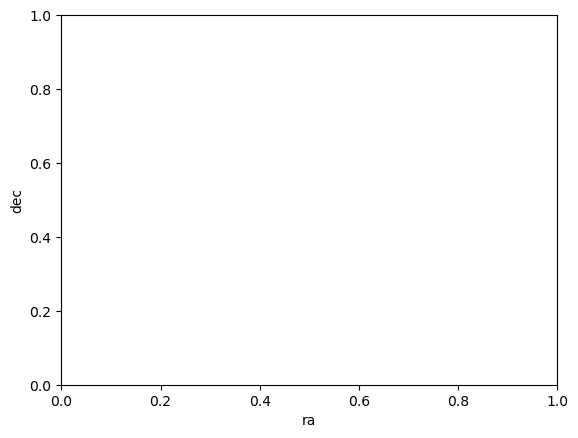

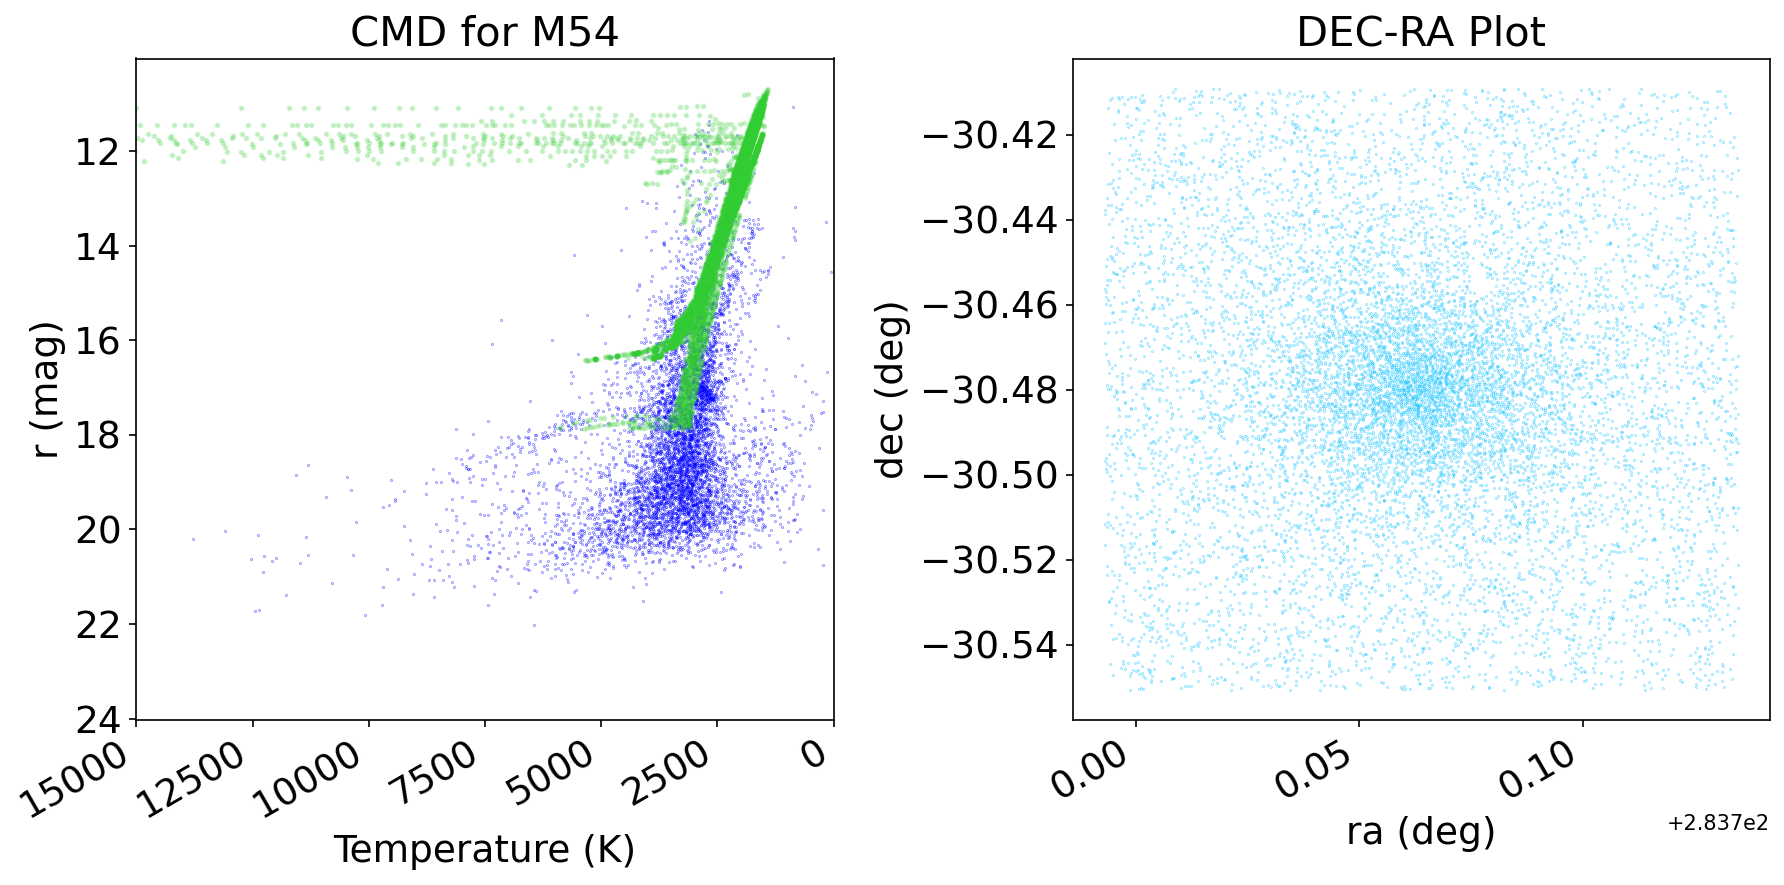

IC Barrier:  1
----- VariRULE LOG -----
[15, 33, 48, 0]
[6, 22, 21, 7]
[22, 54, 51, 25]
[27, 143, 39, 131]
[10, 26, 29, 7]
[26, 169, 106, 89]
[24, 114, 74, 64]
[26, 96, 87, 35]
[1474, 40, 583, 931]
[21, 55, 52, 24]
[41, 325, 157, 209]
[29, 275, 127, 177]
[1504, 36, 939, 601]
[30, 58, 46, 42]
[96, 1065, 236, 925]
[40, 233, 273, 0]
[113, 953, 219, 847]
[10, 26, 36, 0]
[22, 72, 50, 44]
[26, 186, 73, 139]
[26, 171, 104, 93]
[29, 96, 45, 80]
[244, 18, 43, 219]
[92, 369, 190, 271]
[63, 723, 103, 683]
[38, 147, 48, 137]
[114, 1268, 439, 943]
[52, 129, 53, 128]
[165, 617, 237, 545]
[29, 262, 122, 169]
[24, 128, 73, 79]
[26, 194, 119, 101]
[139, 432, 199, 372]
[85, 195, 127, 153]
[18, 37, 50, 5]
[1172, 81, 237, 1016]
[109, 1237, 423, 923]
[712, 1578, 573, 1717]
[26, 207, 63, 170]
[27, 202, 76, 153]
[32, 253, 59, 226]
[58, 817, 153, 722]
[40, 152, 31, 161]
[72, 611, 112, 571]
[99, 580, 227, 452]
[23, 70, 64, 29]
[10, 27, 37, 0]
[22, 50, 71, 1]
[1367, 3, 783, 587]
[2587, 0, 593, 1994]
[27, 219, 1

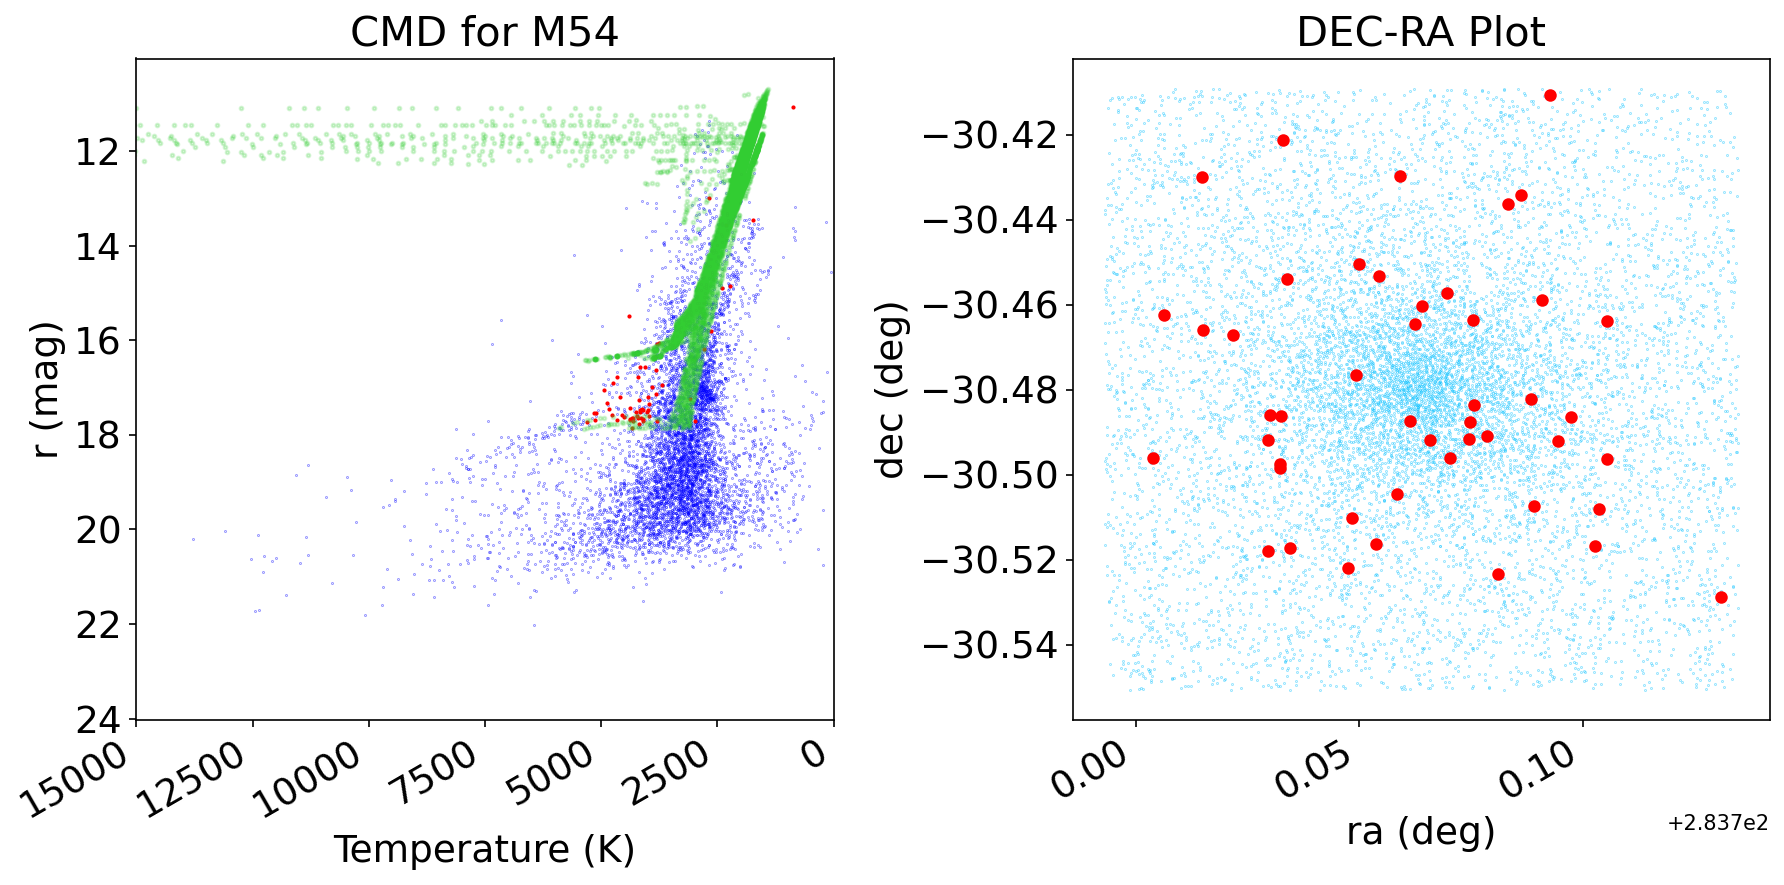

PermissionError: [Errno 13] Permission denied: 'GCdata.xlsx'

In [23]:
# Coloring of non-RRL variable stars is removed
for rowNumber in [57]:
    gaiaAnalyzeIsochroneDataDict(ic_barrier=1, plot_vari=True, variRuleLog=True, force_manual_dim=False, set_xlim_first=15000, do_isochrone=True, x_search_error=1000, y_search_error=1, data_file = 'GCdata.xlsx', row_number = rowNumber, search_rows = 1e7, df_error=1.0)

In [ ]:
data_file = "GCdata.xlsx"

row_number = 3

wb = load_workbook(data_file)
# Load one worksheet.
ws = wb["RRppm"]
data_dict = {}
headers = [cell.value for cell in ws[1]]
row_data = [cell.value for cell in ws[row_number]]
data_dict = dict(zip(headers, row_data))

ws_backup = wb["RRppm_backup"]
data_dict_backup = {}
headers_backup = [cell.value for cell in ws_backup[1]]
row_data_backup = [cell.value for cell in ws_backup[row_number]]
data_dict_backup = dict(zip(headers_backup, row_data_backup))

first_empty_row = 1
rows = ws_backup.iter_rows(values_only=True)
for row in ws_backup.iter_rows(min_row=1, values_only=True):  # Start from row 2 to skip headers
    if all(cell is None for cell in row):  # Check if all cells in the row are empty
        break
    first_empty_row += 1

if first_empty_row is None:
    first_empty_row = ws_backup.max_row + 1  # If no empty row is found, append to the end
print(f"First empty row in backup sheet: {first_empty_row}")

# @title GAIA+Isochrone (Research Titles)
def gaiaAnalyzeIsochroneDataDict(plot_vari=True, variRuleLog=True, force_manual_dim=False, set_xlim_first=15000, do_isochrone=True, x_search_error=1000, y_search_error=1, data_file = 'GCdata.xlsx', row_number = -1, search_rows = 1e7, df_error=0.4):
    finalLog = "" # Final log of this script
    wb = load_workbook(data_file)
    # Load one worksheet.
    ws = wb["RRppm"]
    data_dict = {}
    headers = [cell.value for cell in ws[1]]
    row_data = [cell.value for cell in ws[row_number]]
    data_dict = dict(zip(headers, row_data))
    
    ws_backup = wb["RRppm_backup"]
    data_dict_backup = {}
    headers_backup = [cell.value for cell in ws_backup[1]]
    row_data_backup = [cell.value for cell in ws_backup[row_number]]
    data_dict_backup = dict(zip(headers_backup, row_data_backup))

    # RA value: convert to degree
    cluster_name = data_dict['Cluster Name']
    ra_h = data_dict['RA_h']
    ra_m = data_dict['RA_m']
    ra_s = data_dict['RA_s']

    print(cluster_name)

    # DEC: convert to degree
    dec_deg = data_dict['DEC_deg']
    dec_min = data_dict['DEC_min']
    dec_sec = data_dict['DEC_sec']
    
    metallicity  = data_dict['Metallicity']
#     age  = data_dict['Age']
    age = 10 # Not much data points for large ages

    mid_ra = ra_h * 15 + ra_m * 0.25 + ra_s / 240
    mid_dec = dec_deg + dec_min / 60 + dec_sec / 3600

    dim_provided = True # Whether the dimensions of the cluster is provided in the Excel file
    dim_min = data_dict.get('Dim_GAIA', -1)
    print(f"Dim_GAIA = {dim_min}")

    dim_deg = dim_min / 60
    search_dim = dim_deg

    # Get the current time
    current_time = datetime.datetime.now()
    # Format the current time into a human-readable string
    formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
    print("Current time:", formatted_time)

    ra_query = "ra BETWEEN " + str(mid_ra - search_dim/2) + " AND " + str(mid_ra + search_dim/2)
    dec_query = "dec BETWEEN " + str(mid_dec - search_dim/2) + " AND " + str(mid_dec + search_dim/2)

    query = f"SELECT TOP {str(int(search_rows))} SOURCE_ID, ra, dec, phot_rp_mean_mag, phot_g_mean_mag, phot_bp_mean_mag FROM gaiadr3.gaia_source WHERE {ra_query} AND {dec_query}"
    print(query)
    job = Gaia.launch_job(query)
    results = job.get_results()
    print("GAIA_SOURCE query completed. Total data count: ", len(results))

    columns = results.colnames

    id_col = findItemInArr(columns, "SOURCE_ID")
    ra_col = findItemInArr(columns, "ra")
    dec_col = findItemInArr(columns, "dec")
    red_col = findItemInArr(columns, "phot_rp_mean_mag")
    green_col = findItemInArr(columns, "phot_g_mean_mag")
    blue_col = findItemInArr(columns, "phot_bp_mean_mag")

    resultIDs = [item[id_col] for item in results]
    assert id_col >= 0 and ra_col >= 0 and dec_col >= 0 and red_col >= 0 and green_col >= 0 and blue_col >= 0, "One or more values are less than 0"

    x1 = []; y1 = []  # CMD plot
    x2 = []; y2 = []  # DEC-RA plot
    L = len(results)
    for item in results:
        # id_ = int(item[id_col])
        apparent_g = item[green_col]
        apparent_b = item[blue_col]
        apparent_r = item[red_col]
        ra = item[ra_col]
        dec = item[dec_col]

        x1.append(brToTemp(apparent_b - apparent_r))
        # x1.append(apparent_b - apparent_r)
        y1.append(apparent_r)
        x2.append(ra)
        y2.append(dec)

    # print(x1)
    plt.xlabel("ra")
    plt.ylabel("dec")
    assert(len(x1)==len(y1))
    assert(len(x2)==len(y2))

    finalLog += "Total stars before filter: "+str(len(x1))+' ';

    # Additional Query to get source_ids from vari_summary table
    matching_x = []
    matching_y = []
    vari_query = "SELECT source_id FROM gaiadr3.vari_summary WHERE SOURCE_ID IN (" + ", ".join([str(item) for item in resultIDs]) + ")"
    print(vari_query[:200])
    vari_job = Gaia.launch_job(vari_query)
    vari_results = vari_job.get_results()
    # vari_results = vari_job.get_results()
    matching_ids = [int(item['SOURCE_ID']) for item in vari_results] # ID values that show up both in vari_summary and gaia_source
    print(f"VARI_SUMMARY query completed. Number of variable stars: {len(matching_ids)}")
    
    for i, iden in enumerate(matching_ids):
        idx = resultIDs.index(iden) # id() is a Python function, idiot. 20240811 to 1 year ago me
        matching_x.append(x1[idx])
        matching_y.append(y1[idx])

    # Add matching_ids to the "variable_id" column in the worksheet
    variable_id_col = 8
    best_class_col = 9
    class_score_col = 10
    class_best_name=[]

    assert(len(matching_x)==len(matching_y) and len(matching_x)==len(matching_ids))

    # Isochrone lines
    # grid = MISTIsochroneGrid()
    legend_labels = []
    print(f"Metallicity = {metallicity}, age={age}")
    isochrone_data = grid.df.loc[grid.df["feh"].between(metallicity-df_error/2, metallicity+df_error/2) & grid.df["age"].between(age-df_error/2, age+df_error/2)]
    # print("Total rows: ", len(isochrone_data))
    x_isochrone_grid = [math.pow(10, logT) for logT in isochrone_data['logTeff']]
    y_isochrone_grid = [LtoMbol(math.pow(10, logL)) for logL in isochrone_data['logL']]

    print("Grid length, ", len(x_isochrone_grid))
    
    # Select particular points to spread evenly along the y-axis (y-values are as even as possible)
    num_points_to_select = 10000  # Change this to the desired number of points
    selected_indices = []
    y_sorted_indices = sorted(range(len(y_isochrone_grid)), key=lambda k: y_isochrone_grid[k])
    step = len(y_isochrone_grid) // num_points_to_select
    for i in range(num_points_to_select):
        selected_indices.append(y_sorted_indices[i * step])
        
    print("Preliminary GAIA query completed. Moving on to isochrone fitting.")
        
    while True:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)
        shiftX = float(input("Please enter shiftX: "))
        shiftY = float(input("Please enter shiftY: "))
        ic_barrier = int(input("Please enter ic_barrier: "))

        x_isochrone = [x_isochrone_grid[i] for i in selected_indices]
        y_isochrone = [y_isochrone_grid[i] for i in selected_indices]

        x_isochrone_shifted = [item+shiftX for item in x_isochrone]
        y_isochrone_shifted = [item+shiftY for item in y_isochrone]

        variRuleFilter = variRule(x_isochrone_shifted, y_isochrone_shifted, matching_x, matching_y, matching_ids, ic_barrier=ic_barrier, x_search_error=x_search_error, y_search_error=y_search_error, variRuleLog=variRuleLog)

        matching_x_filtered, matching_y_filtered, matching_ids_filtered, discardedVariables = variRuleFilter[0], variRuleFilter[1], variRuleFilter[2], variRuleFilter[3];


        if variable_id_col>=0: # Column found
            # Additional Query to get class results
            class_query = "SELECT SOURCE_ID, best_class_name, best_class_score FROM gaiadr3.vari_classifier_result WHERE source_id IN (" + ", ".join([str(int(item)) for item in matching_ids]) + ")"
            print(class_query[:100] + "...")
            class_job = Gaia.launch_job(class_query)
            class_results = class_job.get_results()
            class_source_ids = [str(item['SOURCE_ID']) for item in class_results]
            class_best_names = [str(item['best_class_name']) for item in class_results]
            class_scores = [float(item['best_class_score']) for item in class_results]
            assert(len(class_source_ids)==len(class_best_names))
            finalLog += "Stars after rule and db search:"+str(len(class_source_ids)) + " "
            print("VARI_CLASSIFIER_RESULT query completed. ")

#             for i in range(1000): #clear data
#                 ws.cell(row=i + 2, column=variable_id_col + 1, value=" ")

#             for i, class_source_id in enumerate(class_source_ids):
#                 if i + 1 < len(all_rows):  # Ensure index is within valid range
#                     ws.cell(row=i + 2, column=variable_id_col + 1, value=class_source_id)

#             for i, class_best_name in enumerate(class_best_names):
#                 if i + 1 < len(all_rows):  # Ensure index is within valid range
#                     ws.cell(row=i + 2, column=best_class_col + 1, value=class_best_name)

#             for i, class_score in enumerate(class_scores):
#                 if i + 1 < len(all_rows):  # Ensure index is within valid range
#                     ws.cell(row=i + 2, column=class_score_col + 1, value=class_score)
            print("EXCEL file modification completed.")

        else:
            print("WARNING: NO COLUMN FOR VARIABLE_ID")

#         wb.save(data_file)
#         print("Excel file: " + data_file + " saved.")

        assert(len(matching_x_filtered)==len(matching_y_filtered))
        vari_count = len(matching_x_filtered)

        # Additional Query to get RA, DEC, and class names of matching stars from vari_classifier_result table
        matching_stars_query = "SELECT vcr.SOURCE_ID, vcr.best_class_name, gs.ra, gs.dec FROM gaiadr3.vari_classifier_result vcr INNER JOIN gaiadr3.gaia_source gs ON vcr.SOURCE_ID = gs.SOURCE_ID WHERE vcr.SOURCE_ID IN ({})".format(", ".join([str(id) for id in matching_ids_filtered]))
        # print(matching_stars_query)
#         ws.cell(row=10, column=1, value=matching_stars_query); sheetRowCounter+=1
        matching_stars_job = Gaia.launch_job(matching_stars_query)
        matching_stars_results = matching_stars_job.get_results()
        matching_columns = matching_stars_results.colnames
        # print(matching_columns)
        matching_ra_col = findItemInArr(matching_columns, "ra")
        matching_ra = [item[matching_ra_col] for item in matching_stars_results]
        # print("matching ra:", matching_ra)
        matching_dec_col = findItemInArr(matching_columns, "dec")
        matching_dec = [item[matching_dec_col] for item in matching_stars_results]
        matching_class_name_col = findItemInArr(matching_columns, 'best_class_name')
        matching_class_names = [item[matching_class_name_col] for item in matching_stars_results]
        matching_length = len(matching_ra)
        print("Matching stars RA, DEC, and class query completed. There are " + str(matching_length) + " matching items.")

        print("Total columns and matching length: %d, %d" %(len(matching_columns), matching_length))
        assert(len(matching_dec)==len(matching_ra))
        assert(len(matching_class_names)==len(matching_ra))
        
        class_occurances = dict(Counter(matching_class_names))
        
        print(class_occurances)

        # Create the right plot (RA vs DEC)
        axs[0].scatter(x1, y1, s=0.03, color='blue', label='Regular Stars')
        axs[1].scatter(x2, y2, s=0.03, color='deepskyblue', label='Non-matching Stars')

        axs[0].set_ylabel("r (mag)", fontsize = 18)
        axs[0].set_xlabel("Temperature (K)", fontsize = 18)
        axs[0].set_xlim(set_xlim_first, 0)
        axs[0].invert_yaxis()

        # axs[0].set_title(star_name + ", radius=" + str(format(search_dim, ".3f")) + "', vari_count=" + str(vari_count) + ", shift=" + str([shiftX, shiftY]))
        axs[0].set_title(f"CMD for {cluster_name}", fontsize = 20)
        axs[1].set_title(f"DEC-RA Plot", fontsize = 20)

        axs[1].set_xlabel("ra (deg)", fontsize = 18)
        axs[1].set_ylabel("dec (deg)", fontsize = 18)

        axs[0].tick_params(axis='x', labelsize=18)
        axs[0].tick_params(axis='y', labelsize=18)
        axs[1].tick_params(axis='x', labelsize=18)
        axs[1].tick_params(axis='y', labelsize=18)

        # Rotate the tick numbers
        plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
        plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')


        if plot_vari:
            for i in range(matching_length):
                x = matching_ra[i]
                y = matching_dec[i]
                class_name = matching_class_names[i]

                color_selection = color_selector(class_name)
                if class_name!="": # Color the dots by their star type
                    if color_selection[0]:
                        axs[1].text(x, y, class_name, fontsize=6, color=color_selection[1])
                    if color_selection[1]:
                        axs[1].scatter(x, y, s=12, color=color_selection[1])

            axs[0].scatter(matching_x_filtered, matching_y_filtered, s=1, color='red', label='Variable Stars')

        if do_isochrone:
            print(f"Plotting isochrone. # of isochrone points: {len(x_isochrone_shifted)}")
            print("x_isochrone_shifted: ", x_isochrone_shifted[:10])
            print("y_isochrone_shifted: ", y_isochrone_shifted[:10])
            axs[0].scatter(
              x_isochrone_shifted,
              y_isochrone_shifted,
              label=f'[Fe/H] = {metallicity}',
              s=3,
              color='limegreen',
              alpha=0.2
            )


        # Add label to the legend
        legend_labels.append(f'[Fe/H] = {metallicity}')
        # Create the dictionary

        # Get the current time
        current_time = datetime.datetime.now()
        # Format the current time into a human-readable string
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
        print("Current time:", formatted_time)
        
        parameters_dict = {
            "timestamp": formatted_time,
            "force_manual_dim": force_manual_dim,
            "set_xlim_first": set_xlim_first,
            "do_isochrone": do_isochrone,
            "df_error": df_error,
            "cluster_name": cluster_name,
            "age": age,
            "metallicity": metallicity,
            "shiftX": shiftX,
            "shiftY": shiftY,
            "ic_barrier": ic_barrier,
            "x_search_error": x_search_error,
            "y_search_error": y_search_error,
            "search_dim (degrees)": round(search_dim, 5),
            "# stars": len(x1),
            "# total variable stars": len(matching_ids),
            "# discarded variable stars": discardedVariables,
            "# RR Lyrae": class_occurances["RR"]
        }
        
        first_empty_row = 1
        rows = ws_backup.iter_rows(values_only=True)
        for row in ws_backup.iter_rows(min_row=1, values_only=True):  # Start from row 2 to skip headers
            if all(cell is None for cell in row):  # Check if all cells in the row are empty
                break
            first_empty_row += 1

        if first_empty_row is None:
            first_empty_row = ws_backup.max_row + 1  # If no empty row is found, append to the end
        print(f"First empty row in backup sheet: {first_empty_row}")
        
        for key, value in parameters_dict.items():
            ws.cell(row=row_number, column=headers.index(key) + 1, value=value)
            ws_backup.cell(row=first_empty_row, column=headers_backup.index(key) + 1, value=value)

        print("===FINAL LOG===")
        finalLog += " Discarded Variable Stars: " + str(discardedVariables) + "\n"
        # Create the string in the specified format
        table_str = "Parameter\tValue\n"
        for key, value in parameters_dict.items():
            table_str += f"{key}\t{value}\n"

        # Print the table
        print(table_str)

        # Copy the table to the clipboard
        pyperclip.copy(table_str)

        # axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

        plt.tight_layout(w_pad=2)
        plt.savefig(f'RRppm_imgs/{cluster_name}-shiftX={shiftX}-shiftY={shiftY}-ic={ic_barrier}-{get_formatted_time()}.png')
        plt.show()
    
        wb.save(data_file)
        
        if (input("Satisfied with the result? Enter 1 if yes, 0 otherwise: ")=="1"):
            break
